dataset source : https://download.pytorch.org/tutorial/data.zip

In [132]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import numpy as np

from torch.utils import data
import matplotlib.pyplot as plt

# Get cpu, gpu or mps device for training.
device = (
    "cuda" 
    if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Loading Data

In [133]:
def get_name_files(path = 'data/names/*.txt'): 
    import glob
    return glob.glob(path)

def read_name_file(path):
    with open(path,encoding='utf-8') as fp:
        return fp.read().split('\n')

def read_name_files(path = 'data/names/*.txt'):
    data = {}
    import os
    for name_file_path in get_name_files(path):
        dir, file_name = os.path.split(name_file_path)
        lang_name, ext = os.path.splitext(file_name)
        data[lang_name] = read_name_file(name_file_path)
    return data
dataset = read_name_files()

In [134]:
def preprocess(name:str):
    return name.lower()
name_lang_corspd = {preprocess(lang):[preprocess(name) for name in names] for lang,names in dataset.items()}
len(dataset.keys()) # categories number

18

# Data Exploration

In [135]:
all_names = []
for lang,names in name_lang_corspd.items():
    all_names.extend(names)
    print(f'-- {lang} : {len(names)} instance --')
    print(names[:5])
len(all_names)

-- arabic : 2001 instance --
['khoury', 'nahas', 'daher', 'gerges', 'nazari']
-- chinese : 269 instance --
['ang', 'au-yong', 'bai', 'ban', 'bao']
-- czech : 520 instance --
['abl', 'adsit', 'ajdrna', 'alt', 'antonowitsch']
-- dutch : 298 instance --
['aalsburg', 'aalst', 'aarle', 'achteren', 'achthoven']
-- english : 3669 instance --
['abbas', 'abbey', 'abbott', 'abdi', 'abel']
-- french : 278 instance --
['abel', 'abraham', 'adam', 'albert', 'allard']
-- german : 725 instance --
['abbing', 'abel', 'abeln', 'abt', 'achilles']
-- greek : 204 instance --
['adamidis', 'adamou', 'agelakos', 'akrivopoulos', 'alexandropoulos']
-- irish : 233 instance --
['adam', 'ahearn', 'aodh', 'aodha', 'aonghuis']
-- italian : 710 instance --
['abandonato', 'abatangelo', 'abatantuono', 'abate', 'abategiovanni']
-- japanese : 992 instance --
['abe', 'abukara', 'adachi', 'aida', 'aihara']
-- korean : 95 instance --
['ahn', 'baik', 'bang', 'byon', 'cha']
-- polish : 140 instance --
['adamczak', 'adamczyk', 

20092

In [136]:
chars = ''.join(all_names)
char_set = set(chars)
# 0.0004 ratio between full dataset and feature number, we can just include non-ascii charset
len(char_set),len(chars),len(char_set)/len(chars)

(58, 143622, 0.0004038378521396443)

In [137]:
lengths = [len(name) for name in names]
np.mean(lengths),max(lengths)

(3.5945945945945947, 6)

In [138]:
non_ascii_names = [name for name in all_names if not name.isascii()]
non_ascii_names[:5]

['bélanger', 'béringer', 'coté', 'émile', 'félix']

# Dataset Development

In [139]:
int_to_class = sorted(name_lang_corspd.keys())
class_to_int = {cls:i for i,cls in enumerate(int_to_class)}

In [140]:
char_to_int = {ch:i+1 for i,ch in enumerate(sorted(list(char_set)))}
char_to_int[''] = 0
int_to_char = {i:ch for ch,i in char_to_int.items()}
int_to_char[0] = '<UNKNOWN>'
vocab_size = len(int_to_char)
vocab_size

59

In [141]:
def build_dataset(name_lang_corspd:dict[str,list[str]], MAX_LEN=6):
    X,y = [],[]
    for lang,names in name_lang_corspd.items():
        for name in names:
            nums = tuple(char_to_int[ch] for ch in name)
            nums = torch.tensor(nums)
            nums = F.pad(nums,(MAX_LEN-len(nums),0))
            cls_id = class_to_int[lang]
            X.append(nums)
            y.append(cls_id)
    X = torch.cat(X).view(-1,6)
    # X = F.one_hot(X,num_classes=vocab_size).float()
    y = torch.tensor(y)
    return X,y
X,y = build_dataset(name_lang_corspd)
idx = torch.randperm(X.size(0))
X,y = X[idx],y[idx]
size = X.size(0)
train_sz = 0.8
dev_sz = 0.05
n1 = int(size*train_sz)
n2 = n1 + int(size*dev_sz)
idx = torch.randperm(size)
Xtr,ytr = X[:n1],y[:n1]
Xdev,ydev = X[n1:n2],y[n1:n2]
Xte,yte = X[n2:],y[n2:]
[tmp.shape for tmp in [Xtr,ytr,Xdev,ydev,Xte,yte]]

[torch.Size([16073, 6]),
 torch.Size([16073]),
 torch.Size([1004, 6]),
 torch.Size([1004]),
 torch.Size([3015, 6]),
 torch.Size([3015])]

In [142]:
tmp = yte
tmp.bincount() / tmp.size(0)

tensor([0.0952, 0.0163, 0.0249, 0.0113, 0.1801, 0.0153, 0.0358, 0.0123, 0.0116,
        0.0358, 0.0481, 0.0030, 0.0046, 0.0033, 0.4723, 0.0063, 0.0199, 0.0040])

# Model Development

In [143]:
class Name_Lang_Classifier(nn.Module):
    def __init__(self,vocab_size,embed_sz,num_classes,hidden_size=12,num_layers=1,dropout=0):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size,embed_sz),
        )
        # LSTM also receive
        #   h - hidden state
        #   c - cell state
        self.rnn = nn.LSTM(embed_sz,hidden_size,num_layers,batch_first=True,dropout=dropout)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, num_classes),
            nn.LogSoftmax(1)
        )
    def forward(self,x,state=None):
        # x : (batch_sz,seq_len,input_sz)
        x = self.embed(x.long())
        x,_ = self.rnn(x,state)
        # -> x - (batch_sz,seq_len,hidden_sz),
        x = x[:,-1]
        x = self.linear(x)
        return x
    def init_hidden(self,batch_sz=1,is_batch=True):
        # h,c : (n_layers,batch_sz,hidden_sz)
        num_layers = self.rnn.num_layers
        hidden_sz = self.rnn.hidden_size
        if is_batch:
            # return torch.zeros(num_layers,batch_sz, hidden_sz)
            return (torch.zeros(num_layers,batch_sz, hidden_sz),
                    torch.zeros(num_layers,batch_sz, hidden_sz))
        else:
            # return torch.zeros(num_layers, hidden_sz)
            return (torch.zeros(num_layers, hidden_sz),
                    torch.zeros(num_layers, hidden_sz))

model = Name_Lang_Classifier(len(char_to_int),10,len(class_to_int))
X,y = Xte,yte
h = model.init_hidden(X.size(0))
print("--in--")
print(X.shape,y.shape)
print("--intermediate--")
pred = model(X.long(),h)
print("--out--")
print(pred.shape)

loss_fn = nn.CrossEntropyLoss()
loss_fn(pred,y)

probs = pred.exp()
probs = probs.sum(1)
assert(torch.isclose(torch.ones_like(probs),probs).all().item())

--in--
torch.Size([3015, 6]) torch.Size([3015])
--intermediate--
--out--
torch.Size([3015, 18])


In [144]:
def train(model,dataset:data.DataLoader,loss_fn,optimizer):
    model.train()
    train_hist = []
    h = None
    for X,y in dataset:
        X = X.to(device)
        y = y.to(device)
        
        # backprop through time
        # h = tuple([each.data.to(device) for each in h])
        
        # forward pass
        pred = model(X,h)
        loss = loss_fn(pred,y)
        
        # clip
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_hist.append(loss.item())
    
    return train_hist

In [145]:
model = Name_Lang_Classifier(len(char_to_int),20,len(class_to_int),128,2,0.5).to(device)
loss_fn = nn.CrossEntropyLoss()

In [146]:
train_hist = []
test_hist = []

In [147]:
train_data_batches = data.DataLoader(data.TensorDataset(Xtr,ytr), batch_size=64, shuffle=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch = 10
for i in range(epoch):
   train(model,train_data_batches,loss_fn,optimizer)
   model.eval()
   with torch.no_grad():
        X,y = Xtr,ytr
        pred = model(X.to(device))
        loss = loss_fn(pred,y.to(device))
        train_hist.append(loss.item())
        
        X,y = Xte,yte
        pred = model(X.to(device))
        loss = loss_fn(pred,y.to(device))
        test_hist.append(loss.item())

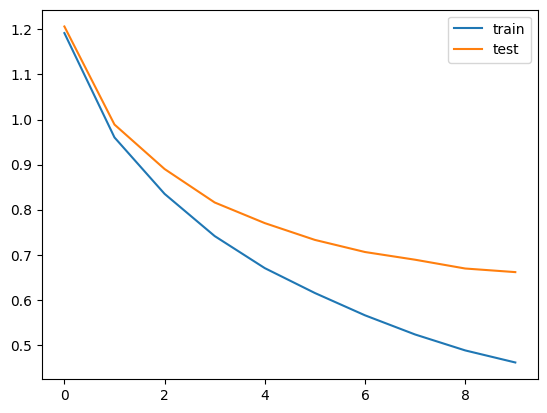

In [148]:
plt.plot(train_hist,label='train')
plt.plot(test_hist,label='test')
plt.legend()

In [149]:
with torch.no_grad():
    X,y = Xte,yte
    pred = model(X.to(device))
    pred = pred.argmax(1)
    correct_count = (pred == y.to(device))
    # print(correct_count.sum())
    print(correct_count.sum()/pred.size(0))

tensor(0.7990, device='cuda:0')


<Figure size 1500x1500 with 0 Axes>

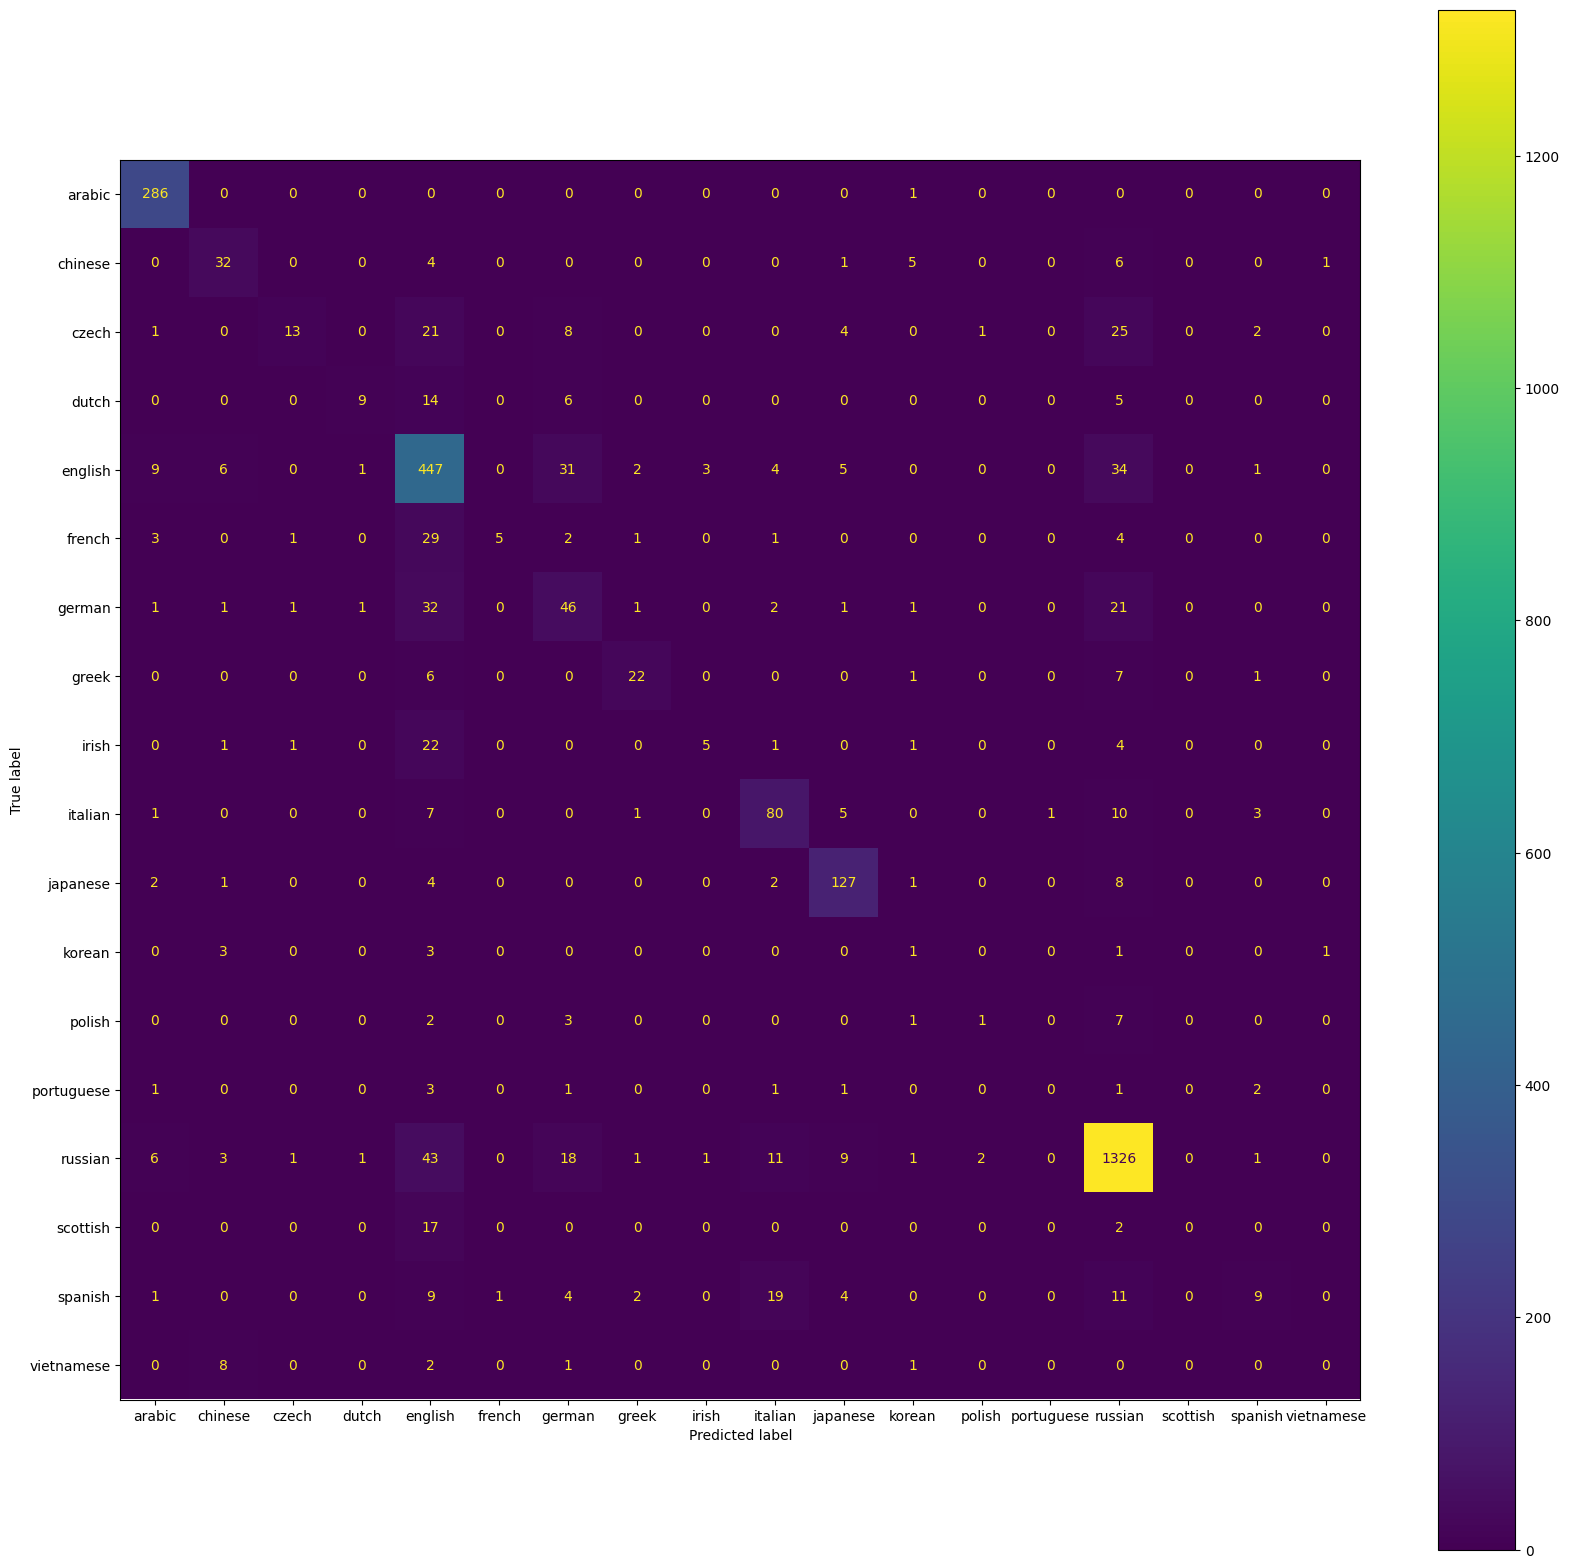

In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
mat = confusion_matrix(y.cpu(),pred.cpu(),normalize=None)
plt.figure(figsize=(15,15))
fig, ax = plt.subplots(figsize=(20,20))
ConfusionMatrixDisplay(mat,display_labels=int_to_class).plot(ax=ax)
fig.savefig('conmat')